# Intro to Deep Learning Systems : Homework 1
## Linear Separability

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit, polyval
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from datetime import datetime, timedelta

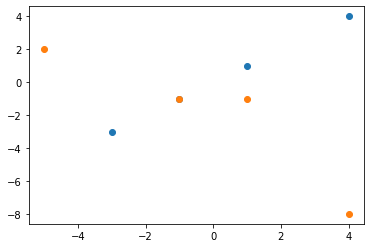

In [2]:
c1, c2 = np.array([[-1, -1], [1, 1], [-3, -3], [4, 4]]), np.array([[-1, -1], [1, -1], [-5, 2], [4, -8]])

plt.scatter(c1[:, 0], c1[:, 1])
plt.scatter(c2[:, 0], c2[:, 1])
plt.savefig("plot_1_1.pdf")

Given the intersection of data points, they are not linearly separable.

[1, 1, 9, 16]


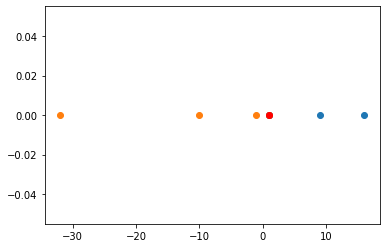

In [3]:
transform = lambda a: a[0]*a[1]
z1, z2 = [transform(x) for x in c1], [transform(x) for x in c2]
print(z1)
plt.scatter(z1, np.zeros_like(z1))
plt.scatter(z2, np.zeros_like(z2))
plt.scatter(1, 0, color="red")
plt.savefig("plot_1_2.pdf")

## Bias Variance Tradeoff, Regularization

/var/folders/sf/dnhwpw5j4gdfml0m9b2sgyb00000gn/T/ipykernel_26329/2412662315.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


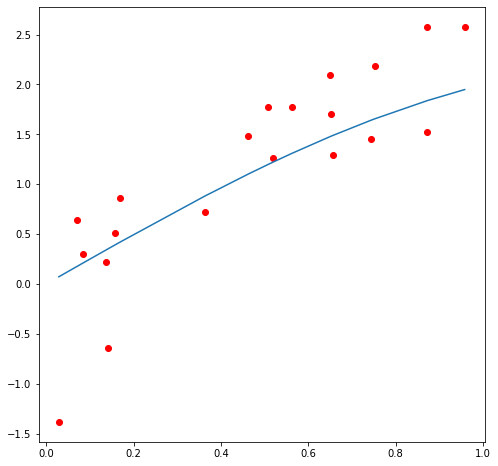

In [4]:
# Generate random data points
f = lambda a: a + np.sin(1.5 * a)

def generate_y(b):
    return f(b) + np.random.normal(loc=0, scale=np.sqrt(0.3), size=b.shape[0])

x = np.sort(np.random.rand(20))
y = generate_y(x)
fig = plt.figure(figsize=(8, 8))
plt.scatter(x, y, color="red")
plt.plot(x, f(x))
fig.savefig("plot_2_1.pdf")
fig.show()

### Estimation

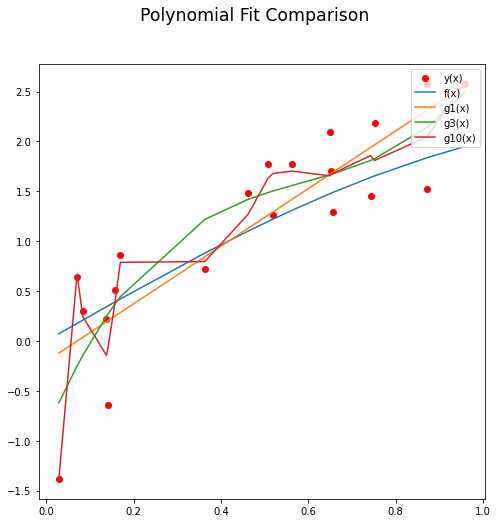

In [5]:
# Define polynomial terms
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Polynomial Fit Comparison", fontsize="xx-large")
plt.scatter(x, y, color="red", label="y(x)")
plt.plot(x, f(x), label="f(x)")
for i in [1, 3, 10]:
    theta = polyfit(x, y, i)
    y_pred = polyval(x, theta)
    plt.plot(x, y_pred, label=f"g{i}(x)")

plt.legend(loc="upper right", fontsize="medium")
plt.savefig("plot_2_2.pdf")
plt.show()


Based on the above, `g1(x)` seems to be **underfitting** while `g3(x)` and`g10(x)` seem to be **overfitting**.

### Model Complexity Analysis

/var/folders/sf/dnhwpw5j4gdfml0m9b2sgyb00000gn/T/ipykernel_26329/778944061.py:56: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


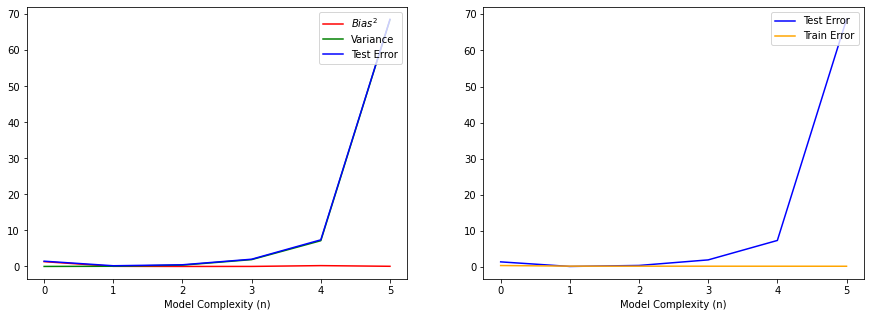

In [6]:
# Define simulation params and metrics
poly_degrees = range(0,6)
sample_size = 50
test_size = sample_size // 5
poly_metrics = {}

# Sample data
X = np.sort(np.random.rand(sample_size))
X_train, X_test = X[test_size:], X[:test_size]
y_test = generate_y(X_test)


# Run simulations
for _ in range(100):
    y_train = generate_y(X_train)
     
    for deg in poly_degrees:
        train_poly, test_poly = PolynomialFeatures(deg).fit_transform(X_train.reshape(-1, 1)), PolynomialFeatures(deg).fit_transform(X_test.reshape(-1, 1))
        model = LinearRegression()
        model.fit(train_poly, y_train)
        y_pred = model.predict(test_poly)
        y_pred_train = model.predict(train_poly)
        
        # Update metrics
        test_error = mean_squared_error(y_test, y_pred)
        train_error = mean_squared_error(y_train, y_pred_train)
        metrics = poly_metrics.get(deg, {"pred_test": [], "train_error": [], "test_error": []})
        metrics["pred_test"].append(y_pred)
        metrics["test_error"].append(test_error)
        metrics["train_error"].append(train_error)
        poly_metrics[deg] = metrics

# Compute final metrics
for deg in poly_degrees:
    metrics = poly_metrics[deg]
    pred = np.array(metrics["pred_test"])
    average_model_prediction = pred.mean(0)
        
    bias_squared = np.mean((average_model_prediction - f(X_test)) ** 2)
    variance = np.mean((pred - average_model_prediction) ** 2)
    
    metrics["bias_squared"] = bias_squared
    metrics["variance"] = variance

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(poly_degrees, [np.mean(poly_metrics[deg]["bias_squared"]) for deg in poly_degrees], label=r"$Bias^2$", color="red")
axes[0].plot(poly_degrees, [np.mean(poly_metrics[deg]["variance"]) for deg in poly_degrees], label="Variance", color="green")
axes[0].plot(poly_degrees, [np.mean(poly_metrics[deg]["test_error"]) for deg in poly_degrees], label="Test Error", color="blue")
axes[0].legend(loc="upper right", fontsize="medium")
axes[0].set_xlabel("Model Complexity (n)")
axes[1].plot(poly_degrees, [np.mean(poly_metrics[deg]["test_error"]) for deg in poly_degrees], label="Test Error", color="blue")
axes[1].plot(poly_degrees, [np.mean(poly_metrics[deg]["train_error"]) for deg in poly_degrees], label="Train Error", color="orange")
axes[1].legend(loc="upper right", fontsize="medium")
axes[1].set_xlabel("Model Complexity (n)")
fig.savefig("plot_2_4.pdf")
fig.show()

### Regularization

In [7]:
# Sample Data
sample_size = 50
test_size = sample_size // 5
X = np.sort(np.random.rand(sample_size))
X_train, X_test = X[test_size:], X[:test_size]
y_train, y_test = generate_y(X_train), generate_y(X_test)

X_train_poly = PolynomialFeatures(10).fit_transform(X_train.reshape(-1, 1))
lin_reg, ridge_reg = LinearRegression(), Ridge(alpha=0.1)

lin_reg.fit(X_train_poly, y_train)
ridge_reg.fit(X_train_poly, y_train)

X_test_poly = PolynomialFeatures(10).fit_transform(X_test.reshape(-1, 1))
pred_lin, pred_ridge = lin_reg.predict(X_test_poly), ridge_reg.predict(X_test_poly)

lin_bias, lin_variance, lin_mse = np.mean(np.mean(pred_lin) - f(X_test)), np.var(pred_lin), mean_squared_error(y_test, pred_lin)
ridge_bias, ridge_variance, ridge_mse = np.mean(np.mean(pred_ridge) - f(X_test)), np.var(pred_ridge), mean_squared_error(y_test, pred_ridge)

print(f"Linear Regression: Bias: {lin_bias}, Variance: {lin_variance}, MSE: {lin_mse}")
print(f"Ridge Regression: Bias: {ridge_bias}, Variance: {ridge_variance}, MSE: {ridge_mse}")

Linear Regression: Bias: 3471.6847771980406, Variance: 20581485.169992458, MSE: 32635709.045787465
Ridge Regression: Bias: 0.055736864782922745, Variance: 0.018817965772059825, MSE: 0.26852461451143267


## Performance Scaling
### Penguins Dataset

In [8]:
penguins_df = pd.read_csv("penguins.csv")
penguins_df = penguins_df.loc[penguins_df.sex != "?"]

In [9]:
cat_features = ['species', 'island', 'sex']
num_cat_features = len(penguins_df.loc[:, penguins_df.columns.isin(cat_features)].columns)

print("Penguins Dataset Details")
print(f"Num. Features: {penguins_df.shape[1]}")
print(f"Num. Instance: {penguins_df.shape[0]}")
print(f"Num. Classes: {penguins_df['species'].nunique()}")
print(f"Num. Numerical Features: {penguins_df.shape[1] - num_cat_features}")
print(f"Num. Categorical Features: {num_cat_features}")

Penguins Dataset Details
Num. Features: 7
Num. Instance: 334
Num. Classes: 3
Num. Numerical Features: 4
Num. Categorical Features: 3


/var/folders/sf/dnhwpw5j4gdfml0m9b2sgyb00000gn/T/ipykernel_26329/3965665012.py:64: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


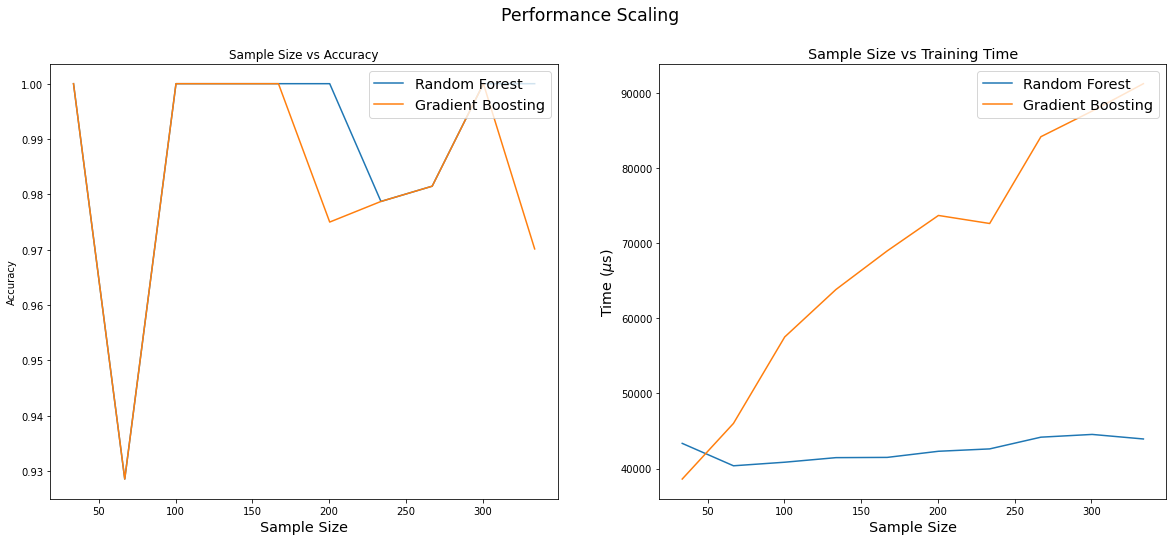

In [10]:
sample_sizes = np.arange(0.1, 1.1, step=0.1)
perf_metrics = {}
accuracy, train_time = {}, {}

for sample_size in sample_sizes:
    # Preprocessing
    data = penguins_df.sample(frac=sample_size, replace=True, random_state=1)
    X, y = data.loc[:, ~penguins_df.columns.isin(['species'])], data['species']
    
    # Numerical features
    X_num = X.loc[:, ~X.columns.isin(cat_features)].astype("float32")
    
    # Categorical feature encoding
    X_cat = X.loc[:, X.columns.isin(cat_features)]
    X_enc = pd.get_dummies(X_cat, prefix=["isl", "sex"])
    y_enc = LabelEncoder().fit_transform(y)
    
    X_final = pd.concat([X_enc, X_num], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_enc, test_size=0.2)
        
    rf, gb = RandomForestClassifier(), GradientBoostingClassifier()
    
    # Train Random Forest
    start = datetime.now()
    rf.fit(X_train, y_train)
    stop = datetime.now()
    
    # Update metrics
    rf_metrics = perf_metrics.get("rf", {})
    rf_metrics["accuracy"] = rf_metrics.get("accuracy", []) + [rf.score(X_test, y_test)]
    rf_metrics["time"] = rf_metrics.get("time", []) + [(stop - start).microseconds]
    perf_metrics["rf"] = rf_metrics
    
    # Train Gradient Boosting
    start = datetime.now()
    gb.fit(X_train, y_train)
    stop = datetime.now()
    
    # Update metrics
    gb_metrics = perf_metrics.get("gb", {})
    gb_metrics["accuracy"] = gb_metrics.get("accuracy", []) + [gb.score(X_test, y_test)]
    gb_metrics["time"] = gb_metrics.get("time", []) + [(stop - start).microseconds]
    perf_metrics["gb"] = gb_metrics

# Plot Accuracy
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Performance Scaling", fontsize="xx-large")
axes[0].plot([data.shape[0] * size for size in sample_sizes], perf_metrics["rf"]["accuracy"], label="Random Forest", scalex=True, scaley=True)
axes[0].plot([data.shape[0] * size for size in sample_sizes], perf_metrics["gb"]["accuracy"], label="Gradient Boosting", scalex=True, scaley=True)
axes[0].set_title("Sample Size vs Accuracy")
axes[0].set_xlabel("Sample Size", fontsize="x-large")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="upper right", fontsize="x-large")

# Plot Runtime
axes[1].plot([penguins_df.shape[0] * size for size in sample_sizes], perf_metrics["rf"]["time"], label="Random Forest", scalex=True, scaley=True)
axes[1].plot([penguins_df.shape[0] * size for size in sample_sizes], perf_metrics["gb"]["time"], label="Gradient Boosting", scalex=True, scaley=True)
axes[1].set_title("Sample Size vs Training Time", fontsize="x-large")
axes[1].set_xlabel("Sample Size", fontsize="x-large")
axes[1].set_ylabel(r"Time ($\mu$s)", fontsize="x-large")
axes[1].legend(loc="upper right", fontsize="x-large")
fig.savefig("plot_3_2_a.pdf")
fig.show()

### Electricity Dataset

In [11]:
sf_police_df = pd.read_csv("sf-police-incidents.csv")
sf_police_df.head()

,Hour,DayOfWeek,Month,Year,PdDistrict,Address,ViolentCrime
0,10,6,7,2005,INGLESIDE,'800 Block of SAN JOSE AV',No
1,10,4,1,2014,CENTRAL,'400 Block of POST ST',No
2,16,3,8,2007,CENTRAL,'500 Block of GEARY ST',No
3,5,7,1,2010,NORTHERN,'600 Block of LARKIN ST',No
4,1,3,6,2008,SOUTHERN,'8TH ST / BRANNAN ST',No


In [12]:
# Preprocessing
cat_features = ['PdDistrict', 'Address', 'ViolentCrime']
target = 'ViolentCrime'
num_cat_features = len(sf_police_df.loc[:, sf_police_df.columns.isin(cat_features)].columns)

print("Electricity Dataset Details")
print(f"Num. Features: {sf_police_df.shape[1]}")
print(f"Num. Instance: {sf_police_df.shape[0]}")
print(f"Num. Classes: {sf_police_df['ViolentCrime'].nunique()}")
print(f"Num. Numerical Features: {sf_police_df.shape[1] - num_cat_features}")
print(f"Num. Categorical Features: {num_cat_features}")

Electricity Dataset Details
Num. Features: 7
Num. Instance: 538638
Num. Classes: 2
Num. Numerical Features: 4
Num. Categorical Features: 3


(43091, 14) (10773, 14)
(86182, 14) (21546, 14)
(129272, 14) (32319, 14)
(172364, 14) (43091, 14)
(215455, 14) (53864, 14)
(258546, 14) (64637, 14)
(301637, 14) (75410, 14)
(344728, 14) (86182, 14)
(387819, 14) (96955, 14)
(430910, 14) (107728, 14)


/var/folders/sf/dnhwpw5j4gdfml0m9b2sgyb00000gn/T/ipykernel_26329/3076526599.py:67: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


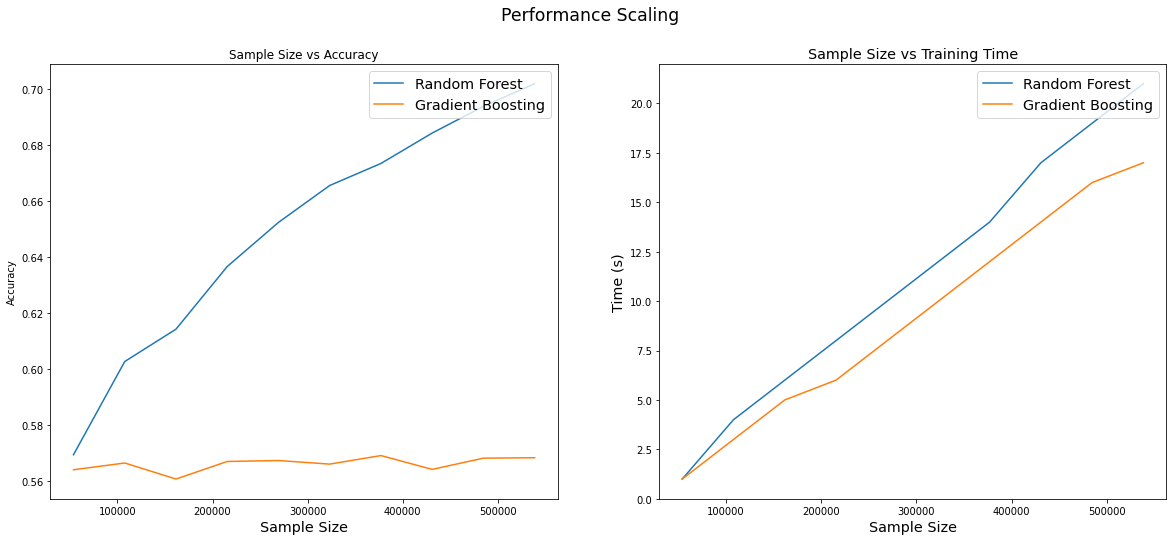

In [13]:
sf_police_df = sf_police_df.loc[:, ~sf_police_df.columns.isin(["Address"])]
sample_sizes = np.arange(0.1, 1.1, step=0.1)
perf_metrics = {}
accuracy, train_time = {}, {}

for sample_size in sample_sizes:
    # Preprocessing
    data = sf_police_df.sample(frac=sample_size, replace=True, random_state=1)
    X, y = data.loc[:, ~data.columns.isin([target])], data[target]
    
    # Numerical features
    X_num = X.loc[:, ~X.columns.isin(cat_features)].astype("float32")
    
    # Categorical feature encoding
    X_cat = X.loc[:, X.columns.isin(cat_features)]
    X_enc = pd.get_dummies(X_cat, prefix=["district"])
    y_enc = LabelEncoder().fit_transform(y)
    
    X_final = pd.concat([X_enc, X_num], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X_final, y_enc, test_size=0.2)
    print(X_train.shape, X_test.shape)
        
    rf, gb = RandomForestClassifier(), GradientBoostingClassifier()
    
    # Train Random Forest
    start = datetime.now()
    rf.fit(X_train, y_train)
    stop = datetime.now()
    
    # Update metrics
    rf_metrics = perf_metrics.get("rf", {})
    rf_metrics["accuracy"] = rf_metrics.get("accuracy", []) + [rf.score(X_test, y_test)]
    rf_metrics["time"] = rf_metrics.get("time", []) + [(stop - start).seconds]
    perf_metrics["rf"] = rf_metrics
    
    # Train Gradient Boosting
    start = datetime.now()
    gb.fit(X_train, y_train)
    stop = datetime.now()
    
    # Update metrics
    gb_metrics = perf_metrics.get("gb", {})
    gb_metrics["accuracy"] = gb_metrics.get("accuracy", []) + [gb.score(X_test, y_test)]
    gb_metrics["time"] = gb_metrics.get("time", []) + [(stop - start).seconds]
    perf_metrics["gb"] = gb_metrics

# Plot Accuracy
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle("Performance Scaling", fontsize="xx-large")
axes[0].plot([data.shape[0] * size for size in sample_sizes], perf_metrics["rf"]["accuracy"], label="Random Forest", scalex=True, scaley=True)
axes[0].plot([data.shape[0] * size for size in sample_sizes], perf_metrics["gb"]["accuracy"], label="Gradient Boosting", scalex=True, scaley=True)
axes[0].set_title("Sample Size vs Accuracy")
axes[0].set_xlabel("Sample Size", fontsize="x-large")
axes[0].set_ylabel("Accuracy")
axes[0].legend(loc="upper right", fontsize="x-large")

# Plot Runtime
axes[1].plot([data.shape[0] * size for size in sample_sizes], perf_metrics["rf"]["time"], label="Random Forest", scalex=True, scaley=True)
axes[1].plot([data.shape[0] * size for size in sample_sizes], perf_metrics["gb"]["time"], label="Gradient Boosting", scalex=True, scaley=True)
axes[1].set_title("Sample Size vs Training Time", fontsize="x-large")
axes[1].set_xlabel("Sample Size", fontsize="x-large")
axes[1].set_ylabel(r"Time (s)", fontsize="x-large")
axes[1].legend(loc="upper right", fontsize="x-large")

fig.savefig("plot_3_2_b.pdf")
fig.show()

## Precision, Recall, ROC

/var/folders/sf/dnhwpw5j4gdfml0m9b2sgyb00000gn/T/ipykernel_26329/2925405506.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


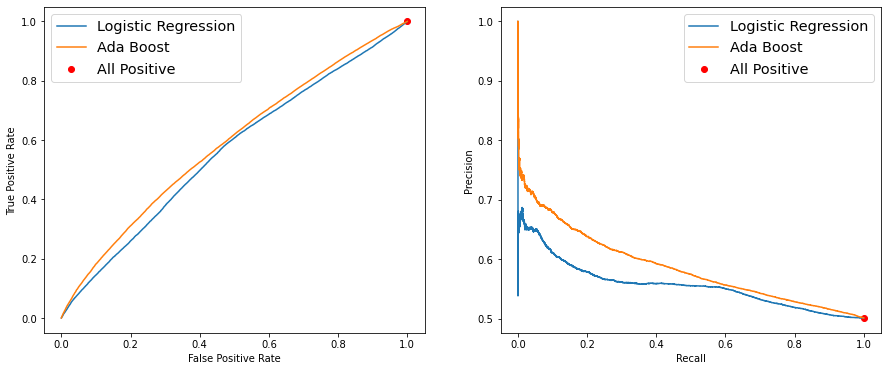

In [14]:
adb, log = AdaBoostClassifier(), LogisticRegression()
log.fit(X_train, y_train)
adb.fit(X_train, y_train)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

y_score_log, y_score_adb = log.decision_function(X_test), adb.decision_function(X_test)

fpr_log, tpr_log, _ = roc_curve(y_test, y_score_log, pos_label=log.classes_[1])
fpr_adb, tpr_adb, _ = roc_curve(y_test, y_score_adb, pos_label=adb.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr_log, tpr=tpr_log).plot(ax=ax1, label="Logistic Regression")
roc_display = RocCurveDisplay(fpr=fpr_adb, tpr=tpr_adb).plot(ax=ax1, label="Ada Boost")
ax1.scatter(tpr_log[-1:], fpr_adb[-1:], color="red", label="All Positive")
ax1.legend(fontsize="x-large")

prec_log, recall_log, _ = precision_recall_curve(y_test, y_score_log, pos_label=log.classes_[1])
prec_adb, recall_adb, _ = precision_recall_curve(y_test, y_score_adb, pos_label=adb.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec_log, recall=recall_log).plot(ax=ax2, label="Logistic Regression")
pr_display = PrecisionRecallDisplay(precision=prec_adb, recall=recall_adb).plot(ax=ax2, label="Ada Boost")
ax2.scatter(recall_adb[:1], prec_adb[:1], color="red", label="All Positive")
ax2.legend(fontsize="x-large")

fig.savefig("plot_4_2.pdf")
fig.show()